In [107]:
import datetime
from pandas_datareader import data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [138]:
#Get data
sector_tickers = pd.read_csv("csv/DJIA.csv")
sector_tickers = sector_tickers["Tickers"].values.tolist()
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime.today()
data = web.DataReader(sector_tickers, 'yahoo', start, end);
list(data)

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

In [139]:
#Isolate Adjusted Close values (typically used for correlations) 
df = data["Adj Close"]
df = (df - df.median())/df.std()   #scale values to be on same range
df.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.775503,1.715077,-1.476568,1.669024,-0.400980,1.631380,0.526787,-1.629564,-0.960339,0.316806,...,-1.486578,-1.731514,1.813340,-0.342581,-2.959787,1.162957,-1.003861,-0.648948,1.705804,1.670959
2015-01-05,-1.075273,1.440584,-1.567103,1.023159,-0.779824,1.159047,0.258093,-1.809649,-1.137676,-0.010797,...,-1.606005,-1.838692,1.720634,-0.561765,-3.234674,0.990843,-1.309490,-0.783494,1.676473,1.134774
2015-01-06,-1.074300,1.225230,-1.720009,0.948586,-0.786712,1.153799,0.146025,-1.874059,-1.341999,-0.216426,...,-1.648937,-1.674773,1.632239,-0.722269,-3.267794,0.847414,-1.396739,-0.621349,1.753906,1.033447
2015-01-07,-0.929281,1.441219,-1.520830,1.127030,-0.614510,1.144353,0.337756,-1.750497,-1.338143,-0.068006,...,-1.499067,-1.403678,1.733569,-0.418519,-3.100543,0.955882,-1.216495,-0.726071,2.022579,1.225545
2015-01-08,-0.526344,1.584464,-1.290465,1.246882,-0.469861,1.403611,0.637505,-1.624306,-1.226344,0.093367,...,-1.328122,-0.993883,1.955631,-0.042284,-2.310654,1.127996,-1.033639,-0.380489,2.241975,1.544301


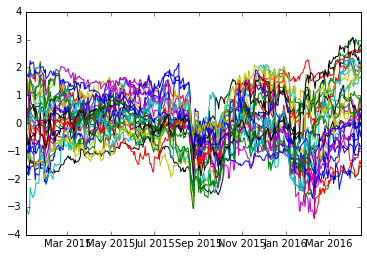

In [140]:
#A messy plot of all the adjusted closing prices
%matplotlib inline
plt.plot(df);

#### Distance Measure for clustering
In order to cluster the stocks we need an inherest distance measurement. The most popular one which we will use is the standard correlation coefficient:

<h3 align="center"> $\rho(x,y) = \frac{cov(x,y)}{\sigma_x \sigma_y} $ </h3>

Other distance measures can be used, like Maximal Information Compression Index, or the Least Square Regression Error, etc.

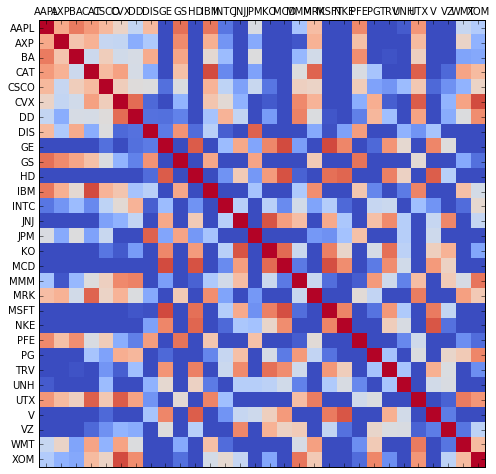

In [141]:
corr = df.corr()
size = 8
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [143]:
#Get highest correlations entries in matrix
thresh = 0.9
a,b = np.where(corr > thresh)   #row,column coords
i = np.delete(a,np.where(a==b))    #remove self-comparison pairs
j = np.delete(b,np.where(a==b))
print str(i.shape[0]/float(corr.shape[0]**2 - corr.shape[0]) )+' of stock pairs have a correlation > '+str(thresh)

0.0137931034483 of stock pairs have a correlation > 0.9


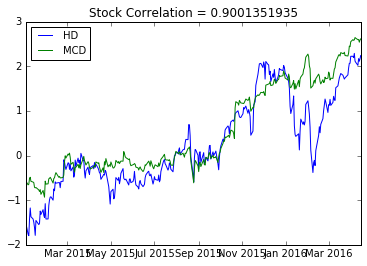

In [148]:
#Plot a sample correlation
stocks = corr.columns
index = 4
x = stocks[i[index]]
y = stocks[j[index]]
plt.plot(df[x], label=x)
plt.plot(df[y], label=y)
plt.title('Stock Correlation = '+str(corr[x][y]))
plt.legend(loc='upper left',prop={'size':10})

### Clusters of Correlation - Agglomerate
The next step is to look for clusters of correlations within a sector. Linkage does the actual clustering, and returns a list of the clusters joined in the format: Z=[idx1, idx2, distance, sample_count]

There are also different options for the measurement of the distance. The option we will choose is the "ward" distance measurement, but others are possible.

In [155]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(corr, 'ward')
Z[0]

array([  3.        ,  18.        ,   0.40598329,   2.        ])

#### Cophenetic Correlation coefficient
It's important to get a sense of how well the clustering performs. One measure is the Cophenetic Correlation Coefficient (c). This compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances.

In [146]:
#Another measure of accuracy is to split the data into N pieces, and perform the clustering on all the chunks.
#If similar results are found then the results can be believed.
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c, coph_dists = cophenet(Z, pdist(corr))
c

0.84732543199061849

#### Dendogram
The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. We can see below that in the DJIA there are 2 main clusters of stocks.

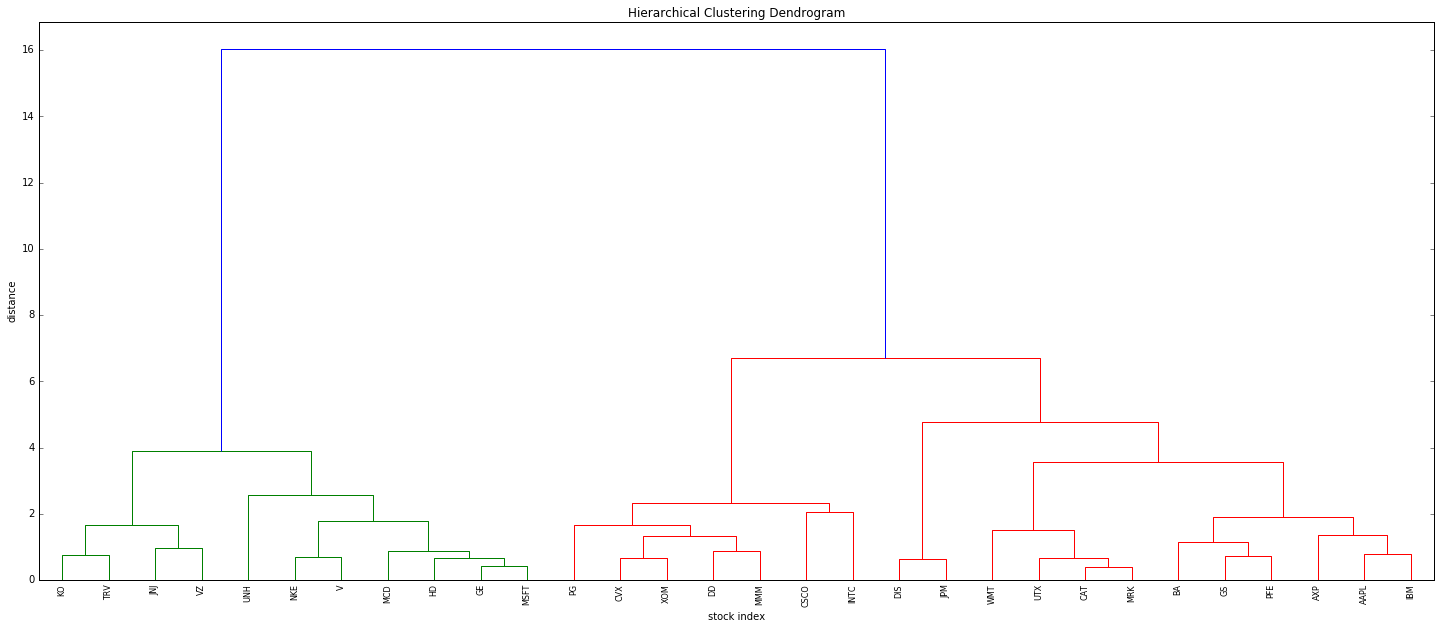

In [161]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('stock index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
plt.savefig('dendogram.pdf')
plt.show()

### Useful links 
#### Clustering
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
http://www.alastairsanderson.com/projects/Dow-Jones-Industrial-Average-stock-clustering-analysis/

#### Libraries
http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html

#### Website Scraping
http://www.thealgoengineer.com/2014/download_sp500_data/